# Тестовое задание на позицию Количественный аналитик

**Тестовое задание выполнено Махамаевым Эмиром**

## Загрузка котировок

Загружаем необходимые библиотеки

In [39]:
!pip install tinkoff-investments
!pip install pyportfolioopt

Я решил загрузить все данные из API Tinkoff, так как на Московской бирже API является платным, а у меня уже есть аккаунт в Tinkoff. Токен имеет только права на чтение и не предоставляет доступ к личной информации, поэтому я выбрал его для использования в этом примере. Тикеры голубых фишек были взяты из индекса голубых фишек Московской биржи

In [40]:
TOKEN = 't.6EjGmX6BnnNh-p2feQGVaIuewQdcX4fdtN6Qhw877enaOY0bSqVkvQZsBEcKiA8jymQYR4fC2sLjzXt5hRFgMA'
blue_chips_russian = ["CHMF", "GAZP", "GMKN", "HEAD", "LKOH", "MOEX", "NLMK", "NVTK", "PLZL", "ROSN", "SBER", "SNGS", "T", "TATN", "YDEX"]

Импортируем необходимые модули

In [41]:
from tinkoff.invest import CandleInterval, Client, SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.caching.market_data_cache.cache import MarketDataCache
from tinkoff.invest.caching.market_data_cache.cache_settings import MarketDataCacheSettings
from pandas import DataFrame
from typing import Dict, List, Optional
from tinkoff.invest.utils import now, quotation_to_decimal
from datetime import datetime, timedelta
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
import numpy as np


from pypfopt import expected_returns, risk_models, EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 100
sns.set_palette('tab10')

Для работы с ценными бумагами необходимо получить их FIGI. Поэтому написал функцию, которая возвращает FIGI по тикеру акции

In [42]:
def get_figies(tickers_to_find):

    tickers_to_find_set = set(tickers_to_find)
    figi_to_ticker = {}

    with Client(TOKEN) as client:
        shares = client.instruments.shares().instruments

        for share in shares:
            if share.class_code == 'TQBR' and share.ticker in tickers_to_find_set:
                figi_to_ticker[share.figi] = share.ticker

    not_found = tickers_to_find_set - set(figi_to_ticker.values())
    if not_found:
        print(f'Не найдены на MOEX: {not_found}')

    return figi_to_ticker

In [43]:
figi_ticker_map = get_figies(blue_chips_russian)
print('Словарь FIGI -> Ticker (MOEX):')
for figi, ticker in figi_ticker_map.items():
  print(f'{ticker}: {figi}')


Словарь FIGI -> Ticker (MOEX):
TATN: BBG004RVFFC0
NVTK: BBG00475KKY8
MOEX: BBG004730JJ5
SNGS: BBG0047315D0
ROSN: BBG004731354
CHMF: BBG00475K6C3
T: TCS80A107UL4
HEAD: TCS20A107662
YDEX: TCS00A107T19
SBER: BBG004730N88
GAZP: BBG004730RP0
NLMK: BBG004S681B4
GMKN: BBG004731489
PLZL: BBG000R607Y3
LKOH: BBG004731032


Теперь загружаем все котировки

In [44]:
def download_stock_data(figi_ticker_map, days = 180):

    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=days)

    prices = pd.DataFrame()

    with Client(TOKEN) as client:
        for figi, ticker in figi_ticker_map.items():
            try:
                candles = client.get_all_candles(
                    figi=figi,
                    from_=start_date,
                    to=end_date,
                    interval=CandleInterval.CANDLE_INTERVAL_DAY
                )

                df = pd.DataFrame([{
                    'date': c.time.date(),
                    ticker: c.close.units + c.close.nano / 1e9
                } for c in candles])

                df.set_index('date', inplace=True)

                if prices.empty:
                    prices = df
                else:
                    prices = prices.join(df, how='outer')

                print(f'Загружены данные для {ticker}')

            except Exception as e:
                print(f'Ошибка при загрузке данных для {ticker}: {e}')

    return prices.sort_index()

# Загружаем данные
prices = download_stock_data(figi_ticker_map)
prices = prices.ffill().dropna()

Загружены данные для TATN
Загружены данные для NVTK
Загружены данные для MOEX
Загружены данные для SNGS
Загружены данные для ROSN
Загружены данные для CHMF
Загружены данные для T
Загружены данные для HEAD
Загружены данные для YDEX
Загружены данные для SBER
Загружены данные для GAZP
Загружены данные для NLMK
Загружены данные для GMKN
Загружены данные для PLZL
Загружены данные для LKOH


In [45]:
print(prices.head())
print('\nОписание:')
print(prices.describe())

             TATN   NVTK    MOEX    SNGS    ROSN    CHMF       T    HEAD  \
date                                                                       
2024-11-19  545.2  875.0  199.08  24.415  459.70  1152.2  2591.0  4360.0   
2024-11-20  536.9  847.8  197.45  23.720  449.25  1120.0  2540.2  4331.0   
2024-11-21  543.5  864.8  198.48  24.420  458.95  1117.8  2576.4  4240.0   
2024-11-22  541.9  822.8  199.01  23.780  459.90  1130.4  2444.8  4251.0   
2024-11-25  515.3  822.8  190.28  23.095  453.65  1101.4  2339.6  4155.0   

              YDEX    SBER    GAZP    NLMK    GMKN    PLZL    LKOH  
date                                                                
2024-11-19  3560.0  240.59  125.49  126.26  111.00  1441.8  6842.0  
2024-11-20  3460.0  237.05  121.89  122.88  108.28  1441.0  6798.5  
2024-11-21  3509.0  240.47  124.10  123.32  109.32  1442.2  6938.5  
2024-11-22  3415.0  236.00  119.47  122.68  108.52  1476.2  6940.0  
2024-11-25  3299.5  227.81  117.44  119.16  103.94  1

## 2. Корректировка котировок на сплиты



Данные из Tinkoff уже скорректирированы на сплиты, но цены в абсолютных величинах плохо показывают динамику на графике

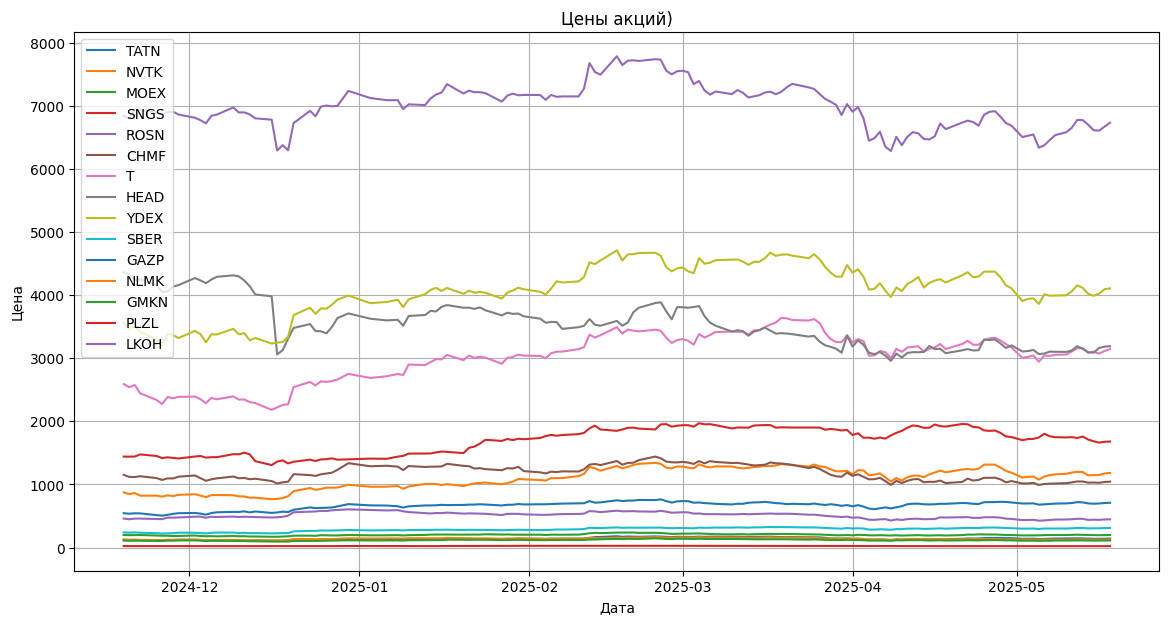

In [46]:
(prices).plot(figsize=(14, 7))
plt.title('Цены акций)')
plt.ylabel('Цена')
plt.xlabel('Дата')
plt.grid(True)
plt.show()

На этом графике представлены относительные величины и поэтому он уже читаемый

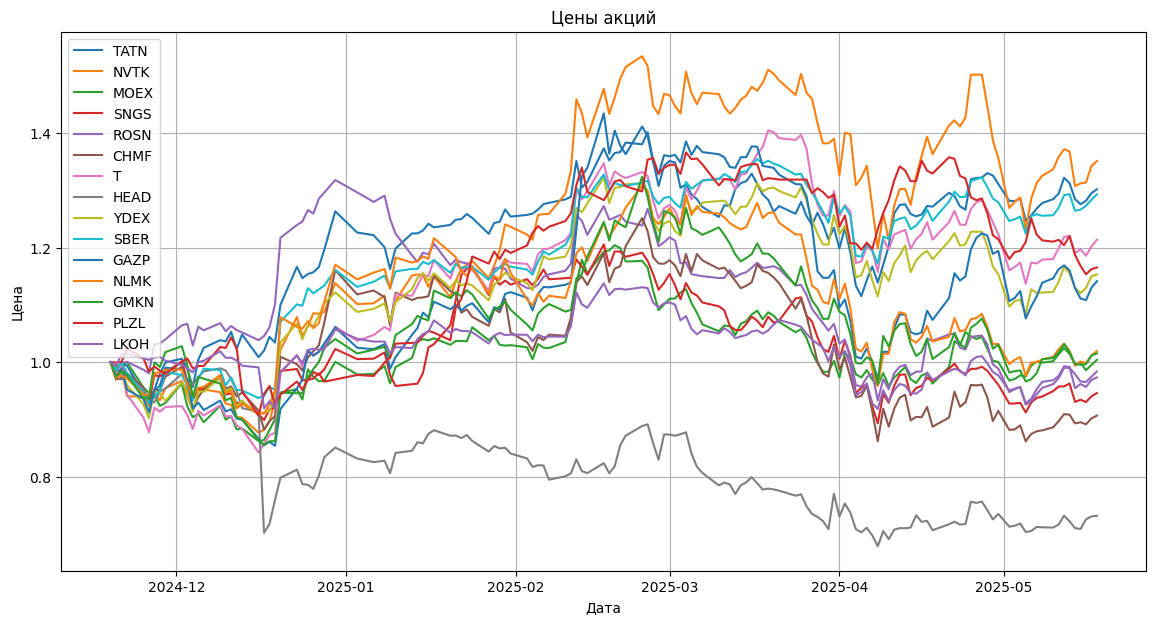

In [47]:
(prices / prices.iloc[0]).plot(figsize=(14, 7))
plt.title('Цены акций')
plt.ylabel('Цена')
plt.xlabel('Дата')
plt.grid(True)
plt.show()

## 3. Mean-Variance Analysis

In [50]:
# Расчитываем доходность и ковариацию
returns = prices.pct_change().dropna()
mu = returns.mean() * 251
S = returns.cov() * 251
risk_free_rate = 0.07

# Оптимизируем портфель

def efficient_portfolio(mu, S, target_return):
    n_assets = len(mu)
    initial_weights = np.ones(n_assets) / n_assets

    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Сумма весов = 1
        {'type': 'ineq', 'fun': lambda w: mu @ w - target_return}
    )
    bounds = [(0, 1) for _ in range(n_assets)]  # Веса от 0 до 1

    # Минимизируем волатильность
    result = minimize(
        fun=lambda w: np.sqrt(w.T @ S @ w),
        x0=initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000}
    )
    return result.x if result.success else None

# Ищем портфель с максимальным коэффициентом Шарпа
def max_sharpe_ratio(mu, S, risk_free_rate=0.04, n_points=100):
    target_returns = np.linspace(mu.min(), mu.max(), n_points)
    sharpes = []
    portfolios = []

    for target in target_returns:
        w = efficient_portfolio(mu, S, target)
        if w is not None:
            ret = mu @ w
            vol = np.sqrt(w.T @ S @ w)
            sharpe = (ret - risk_free_rate) / vol
            sharpes.append(sharpe)
            portfolios.append(w)

    max_sharpe_idx = np.argmax(sharpes)
    return portfolios[max_sharpe_idx]

weights = max_sharpe_ratio(mu, S, risk_free_rate)
cleaned_weights = {asset: round(w, 4) for asset, w in zip(mu.index, weights) if w > 0.01}

# Выводим оптимальные веса
print('Оптимальные веса портфеля:')
for asset, weight in cleaned_weights.items():
    print(f'{asset}: {weight * 100:.2f}%')

# Оцениваем портфель
portfolio_return = mu @ weights
portfolio_vol = np.sqrt(weights.T @ S @ weights)
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_vol

print(f'\nОжидаемая доходность: {portfolio_return * 100:.2f}%')
print(f'Волатильность: {portfolio_vol * 100:.2f}%')
print(f'Коэффициент Шарпа: {sharpe_ratio:.2f}')

Оптимальные веса портфеля:
TATN: 36.04%
NVTK: 8.25%
SBER: 35.99%
PLZL: 19.72%

Ожидаемая доходность: 48.63%
Волатильность: 27.48%
Коэффициент Шарпа: 1.51


Можно попробовать провести анализ через библиотеку pypfopt, что будет короче и понятнее

In [53]:
# Расчитываем доходность и ковариацию
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Оптимизируем портфель
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print('Оптимальные веса портфеля:')
for ticker, w in cleaned_weights.items():
    if w > 0.01:  # Показываем только активы с весом > 1%
        print(f'{ticker}: {w*100:.2f}%')

# Оцениваем портфель
ef.portfolio_performance(verbose=True)

Оптимальные веса портфеля:
TATN: 35.75%
SBER: 46.47%
PLZL: 17.78%
Expected annual return: 54.3%
Annual volatility: 27.1%
Sharpe Ratio: 2.00


(np.float64(0.5426996536065809),
 np.float64(0.27140766552331924),
 np.float64(1.9995737871300188))